In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms as tf
from torchvision.datasets import MNIST

%cd ../
from src.models.models import MNISTClassifier
%cd notebooks/

/home/nazar/Projects/ukrainian_handwriting
/home/nazar/Projects/ukrainian_handwriting/notebooks


In [34]:
device = torch.device('cuda:0')

# Load train/test/val

In [91]:
MEAN = MNISTClassifier._mean
STD = MNISTClassifier._std

tfs = tf.Compose([
    tf.Grayscale(3),
    tf.RandomRotation(45),
    tf.ToTensor(),
    tf.Normalize(MEAN, STD)
])

In [92]:
train_data = MNIST('../data/raw/', train=True, transform=tfs)

test_data = MNIST('../data/raw/', train=False, transform=tf.Compose([
    tf.Grayscale(3), tf.ToTensor(), tf.Normalize(MEAN, STD)]))

print('Number of samples in training data:', len(train_data))
print('Number of samples in test data:', len(test_data))

Number of samples in training data: 60000
Number of samples in test data: 10000


In [93]:
BATCH_SIZE = 64
VAL_SIZE = 5000

indices = list(range(len(train_data)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[VAL_SIZE:], indices[:VAL_SIZE]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_data)

# Functions for training

In [81]:
def compute_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = torch.argmax(model(x_gpu), 1)
        
        correct_samples += torch.sum(prediction == y_gpu)
        total_samples += y.shape[0]
    return float(correct_samples) / total_samples

def train_model(model, train_loader, val_loader, optimizer, loss, num_epochs, scheduler=None):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_acum = 0
        total_samples = 0
        correct_samples = 0
        for i, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_acum += loss_value
        
        average_loss = loss_acum / i
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler:
            scheduler.step(val_accuracy)
        
        loss_history.append(float(average_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'{epoch + 1}. Loss = {average_loss}; Train accuracy = {train_accuracy}; Val accuracy = {val_accuracy}')
    return loss_history, train_history, val_history

def plot_history(loss_h, train_h, val_h) -> None:
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    ax[0].set_title('Loss')
    ax[0].plot(loss_h)
    ax[1].set_title('Train/validation accuracy')
    ax[1].plot(train_h, label='Train')
    ax[1].plot(val_h, label='Validation')
    ax[1].legend(loc='lower right');

# Model training

In [99]:
LR = 0.001
NUM_EPOCHS = 25
REG = 0.001

model = MNISTClassifier()
model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=REG)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

In [100]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, optimizer, loss, NUM_EPOCHS,
                                                       scheduler)

1. Loss = 0.16795293986797333; Train accuracy = 0.9500909090909091; Val accuracy = 0.973
2. Loss = 0.09332962334156036; Train accuracy = 0.9725454545454545; Val accuracy = 0.9742
3. Loss = 0.08388546854257584; Train accuracy = 0.9755818181818182; Val accuracy = 0.9744
4. Loss = 0.08021202683448792; Train accuracy = 0.9763454545454545; Val accuracy = 0.9786
5. Loss = 0.07434315979480743; Train accuracy = 0.9784909090909091; Val accuracy = 0.9788
6. Loss = 0.07340040057897568; Train accuracy = 0.9785090909090909; Val accuracy = 0.981
7. Loss = 0.07170283794403076; Train accuracy = 0.9788; Val accuracy = 0.9776
8. Loss = 0.06835091859102249; Train accuracy = 0.98; Val accuracy = 0.9824
9. Loss = 0.06617849320173264; Train accuracy = 0.9813090909090909; Val accuracy = 0.9758
10. Loss = 0.0663788914680481; Train accuracy = 0.9806727272727273; Val accuracy = 0.9794
11. Loss = 0.06424403190612793; Train accuracy = 0.9818; Val accuracy = 0.9776
12. Loss = 0.06409210711717606; Train accuracy = 

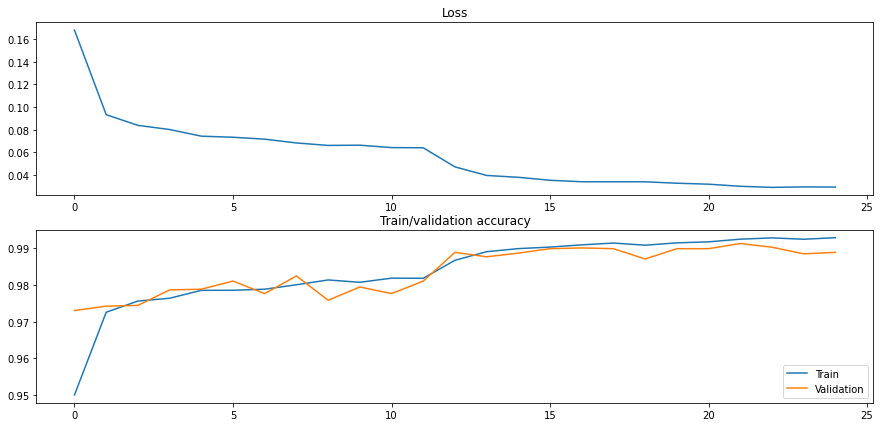

In [101]:
plot_history(loss_history, train_history, val_history)

In [102]:
test_acc = compute_accuracy(model, test_loader)

In [103]:
print(f'Accuracy on test dataset: {test_acc:.2%} ({test_acc})')

Accuracy on test dataset: 99.39% (0.9939)


In [105]:
# save model
torch.save(model.state_dict(), '../models/mnist_model.pt')